In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
import json
import numpy as np
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import gensim.downloader as api
from keras.models import Model
from keras.layers import Embedding, Bidirectional, LSTM, Dense, TimeDistributed, Dropout, Input, Concatenate, Dot, Activation, multiply
from sklearn.metrics import classification_report
from gensim.models import KeyedVectors
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [5]:
word_vectors = api.load('glove-wiki-gigaword-200')

[==================================================] 100.0% 252.1/252.1MB downloaded


In [6]:
def process_data(data):
    stop_words = set(stopwords.words('english'))
    punctuation = set(string.punctuation)

    tokens_list = []
    aspects_list = []
    bio_tags_list = []
    token_length_list = []
    pos_tags_list = []

    for entry in data:
        tokens = [token for token in entry["token"] if token not in punctuation]
        aspects = entry.get("aspects", [])
        pos_tags = nltk.pos_tag(tokens)

        unique_aspects = []
        bio_tags = ['O'] * len(tokens)

        for aspect in aspects:
            term = [char for char in aspect.get("term", []) if char not in punctuation]
            unique_aspects.append(''.join(term))

            for i in range(len(tokens)):
                if tokens[i:i + len(term)] == term:
                    if i > 0 and bio_tags[i - 1] == 'B':
                        bio_tags[i] = 'I'
                    else:
                        bio_tags[i] = 'B'
                    if len(term) > 1:
                        bio_tags[i + 1:i + len(term)] = ['I'] * (len(term) - 1)

        filtered_tokens = tokens
        filtered_bio_tags = bio_tags
        filtered_pos_tags = [tag[1] for tag in pos_tags]

        tokens_list.append(filtered_tokens)
        aspects_list.append(unique_aspects)
        bio_tags_list.append(filtered_bio_tags)
        token_length_list.append([len(token) for token in filtered_tokens])
        pos_tags_list.append(filtered_pos_tags)

    df_result = pd.DataFrame({
        'token': tokens_list,
        'aspect': aspects_list,
        'bioTag': bio_tags_list,
        'pos': pos_tags_list,  # Add POS tags as a new column
    })

    return df_result


Laptop Dataset


In [7]:
# Load training data from JSON file
train_json_file_path_laptop = '/content/drive/MyDrive/Common files/Dataset/Laptops/train.json'
with open(train_json_file_path_laptop, 'r') as file:
    train_data_laptop = json.load(file)
test_json_file_path_laptop = '/content/drive/MyDrive/Common files/Dataset/Laptops/test.json'
with open(test_json_file_path_laptop, 'r') as file:
    test_data_laptop = json.load(file)
valid_json_file_path_laptop = '/content/drive/MyDrive/Common files/Dataset/Laptops/valid.json'
with open(valid_json_file_path_laptop, 'r') as file:
    valid_data_laptop = json.load(file)

In [8]:
df_train_laptop = process_data(train_data_laptop)
df_test_laptop = process_data(test_data_laptop)
df_valid_laptop = process_data(valid_data_laptop)

In [9]:
# Adjust tokenizer with a fixed maximum vocabulary size
MAX_VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train_laptop['token'])
tokenizer.fit_on_texts(df_train_laptop['pos'])

# Set a fixed maximum sequence length
max_seq_length = 200
tag_to_index = {'O': 0, 'B': 1, 'I': 2,'PAD':3}
# Pad sequences with the fixed maximum sequence length
X_train_laptop = pad_sequences(tokenizer.texts_to_sequences(df_train_laptop['token']), maxlen=max_seq_length, padding='post', truncating='post')
X_test_laptop = pad_sequences(tokenizer.texts_to_sequences(df_test_laptop['token']), maxlen=max_seq_length, padding='post', truncating='post')
X_val_laptop = pad_sequences(tokenizer.texts_to_sequences(df_valid_laptop['token']), maxlen=max_seq_length, padding='post', truncating='post')

# Pad POS sequences with the fixed maximum sequence length
pos_vocab_size = len(tokenizer.word_index) + 1
X_train_pos_laptop = pad_sequences(tokenizer.texts_to_sequences(df_train_laptop['pos']), maxlen=max_seq_length, padding='post', truncating='post')
X_test_pos_laptop = pad_sequences(tokenizer.texts_to_sequences(df_test_laptop['pos']), maxlen=max_seq_length, padding='post', truncating='post')
X_val_pos_laptop = pad_sequences(tokenizer.texts_to_sequences(df_valid_laptop['pos']), maxlen=max_seq_length, padding='post', truncating='post')

# Pad BIO tag sequences with the fixed maximum sequence length
y_train_laptop = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_train_laptop['bioTag']], padding='post', value=3, maxlen=max_seq_length)
y_test_laptop = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_test_laptop['bioTag']], padding='post', value=3, maxlen=max_seq_length)
y_val_laptop = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_valid_laptop['bioTag']], padding='post', value=3, maxlen=max_seq_length)

# Convert numerical representations to one-hot encoding
y_train_laptop = to_categorical(y_train_laptop)
y_test_laptop = to_categorical(y_test_laptop)
y_val_laptop = to_categorical(y_val_laptop)

embedding_dim = 200  # Adjust based on the GloVe file you downloaded
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]

# Define L2 regularization strength
l2_reg = 0.01

# Update model architecture with regularization and class weights
def create_model_with_position_embeddings(embedding_matrix, max_seq_length, max_pos_length):
    # Input layers
    token_input_layer = Input(shape=(max_seq_length,))
    pos_input_layer = Input(shape=(max_seq_length,))

    # Word embedding layer
    word_embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                                     output_dim=embedding_matrix.shape[1],
                                     input_length=max_seq_length,
                                     weights=[embedding_matrix],
                                     trainable=True, mask_zero=True)
    token_embedding = word_embedding_layer(token_input_layer)

    # Positional embedding layer
    pos_embedding_layer = Embedding(input_dim=pos_vocab_size,
                                    output_dim=50,
                                    input_length=max_seq_length)
    pos_embedding = pos_embedding_layer(pos_input_layer)

    # Concatenate token embeddings and positional embeddings
    combined_embedding = Concatenate(axis=-1)([token_embedding, pos_embedding])

    # Dropout layer
    dropout_emb = Dropout(0.5)(combined_embedding)

    # Regularization layer
    reg_emb = TimeDistributed(Dense(512, activation='relu', kernel_regularizer=l2(l2_reg)))(dropout_emb)

    # Attention Mechanism
    attention = TimeDistributed(Dense(512, activation='relu'))(reg_emb)
    attention = TimeDistributed(Dense(1))(attention)
    attention = TimeDistributed(Dense(128, activation='relu'))(attention)
    attention = TimeDistributed(Dense(1))(attention)
    attention = Activation('softmax')(attention)

    # Apply attention weights
    sent_representation = multiply([reg_emb, attention])

    # Bidirectional LSTM layer
    lstm = Bidirectional(LSTM(units=100, return_sequences=True))(sent_representation)

    # Self-Attention Mechanism
    self_attention = Dot(axes=[2, 2])([lstm, lstm])
    self_attention = Activation('softmax')(self_attention)

    # Combine attention and self-attention
    combined_attention = Concatenate(axis=-1)([lstm, self_attention])

    # Feedforward layers with regularization
    output = TimeDistributed(Dense(128, activation='tanh', kernel_regularizer=l2(l2_reg)))(combined_attention)
    output = Dropout(0.1)(output)
    output = TimeDistributed(Dense(4, activation='softmax'))(output)  # Assuming 3 classes: 'O', 'B', 'I'

    # Create model
    model = Model(inputs=[token_input_layer, pos_input_layer], outputs=output)

    return model


In [34]:
model_with_position_embeddings = create_model_with_position_embeddings(embedding_matrix, max_seq_length, len(tag_to_index))
model_with_position_embeddings.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
laptop_history = model_with_position_embeddings.fit([X_train_laptop, X_train_pos_laptop], y_train_laptop, validation_data=([X_val_laptop, X_val_pos_laptop], y_val_laptop), epochs=50,batch_size=32,callbacks=[early_stopping])


Epoch 1/50
46/46 [==============================] - 28s 378ms/step - loss: 3.5472 - accuracy: 0.8485 - val_loss: 1.9008 - val_accuracy: 0.8201
Epoch 2/50
46/46 [==============================] - 4s 95ms/step - loss: 1.1556 - accuracy: 0.8692 - val_loss: 0.7908 - val_accuracy: 0.8357
Epoch 3/50
46/46 [==============================] - 4s 93ms/step - loss: 0.5160 - accuracy: 0.8954 - val_loss: 0.4748 - val_accuracy: 0.8714
Epoch 4/50
46/46 [==============================] - 7s 159ms/step - loss: 0.3340 - accuracy: 0.9223 - val_loss: 0.3765 - val_accuracy: 0.8903
Epoch 5/50
46/46 [==============================] - 3s 69ms/step - loss: 0.2721 - accuracy: 0.9308 - val_loss: 0.3090 - val_accuracy: 0.9080
Epoch 6/50
46/46 [==============================] - 2s 42ms/step - loss: 0.2252 - accuracy: 0.9413 - val_loss: 0.2771 - val_accuracy: 0.9164
Epoch 7/50
46/46 [==============================] - 2s 39ms/step - loss: 0.2025 - accuracy: 0.9434 - val_loss: 0.2611 - val_accuracy: 0.9200
Epoch 8/50

In [35]:
from sklearn.metrics import classification_report, accuracy_score

y_pred_laptop = model_with_position_embeddings.predict([X_test_laptop, X_test_pos_laptop])


y_pred_laptop_labels = np.argmax(y_pred_laptop, axis=-1)
y_test_laptop_labels = np.argmax(y_test_laptop, axis=-1)
y_pred_laptop_labels_flat = y_pred_laptop_labels.flatten()
y_test_laptop_labels_flat = y_test_laptop_labels.flatten()

# Generate classification report
class_names = ['O', 'B', 'I']
non_pad_indices = y_test_laptop_labels_flat != tag_to_index['PAD']
y_pred_labels_laptop_filtered = y_pred_laptop_labels_flat[non_pad_indices]
y_test_labels_laptop_filtered = y_test_laptop_labels_flat[non_pad_indices]

# Generate classification report
report = classification_report(y_test_labels_laptop_filtered, y_pred_labels_laptop_filtered, target_names=class_names)


# Print classification report
print("Classification Report (excluding PAD tag):")
print(report)

# Calculate accuracy excluding 'PAD' tag
accuracy = accuracy_score(y_test_labels_laptop_filtered, y_pred_labels_laptop_filtered)
print("Accuracy (excluding PAD tag):", accuracy)


13/13 [==============================] - 2s 9ms/step
Classification Report (excluding PAD tag):
              precision    recall  f1-score   support

           O       0.95      0.98      0.97      4776
           B       0.82      0.78      0.80       623
           I       0.81      0.64      0.72       425

    accuracy                           0.93      5824
   macro avg       0.86      0.80      0.83      5824
weighted avg       0.93      0.93      0.93      5824

Accuracy (excluding PAD tag): 0.9330357142857143


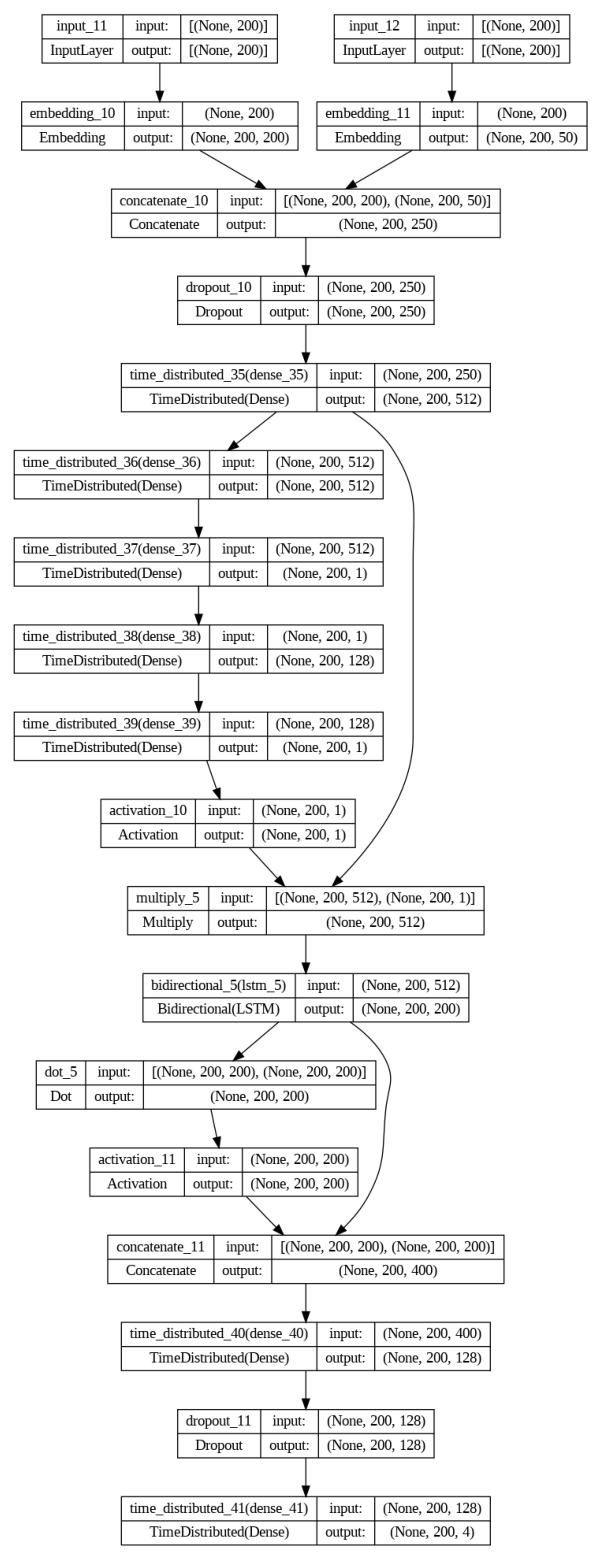

In [36]:
from keras.utils import to_categorical, plot_model
import matplotlib.pyplot as plt
plot_model(model_with_position_embeddings , to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

# Display the model diagram
img = plt.imread('model_diagram.png')
plt.figure(figsize=(20, 20))
plt.imshow(img)
plt.axis('off')
plt.show()

# Restaurants Dataset

In [37]:
# Load training data from JSON file
train_json_file_path_res = '/content/drive/MyDrive/Common files/Dataset/Restaurants/train.json'
with open(train_json_file_path_res, 'r') as file:
    train_data_res = json.load(file)
test_json_file_path_res = '/content/drive/MyDrive/Common files/Dataset/Restaurants/test.json'
with open(test_json_file_path_res, 'r') as file:
    test_data_res = json.load(file)
valid_json_file_path_res = '/content/drive/MyDrive/Common files/Dataset/Restaurants/valid.json'
with open(valid_json_file_path_res, 'r') as file:
    valid_data_res = json.load(file)

In [38]:
df_train_res = process_data(train_data_res)
df_test_res = process_data(test_data_res)
df_valid_res = process_data(valid_data_res)

In [39]:
# Adjust tokenizer with a fixed maximum vocabulary size
MAX_VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train_res['token'])
tokenizer.fit_on_texts(df_train_res['pos'])

max_seq_length = 200
tag_to_index = {'O': 0, 'B': 1, 'I': 2,'PAD':3}
# Pad sequences with the fixed maximum sequence length
X_train_res = pad_sequences(tokenizer.texts_to_sequences(df_train_res['token']), maxlen=max_seq_length, padding='post', truncating='post')
X_test_res = pad_sequences(tokenizer.texts_to_sequences(df_test_res['token']), maxlen=max_seq_length, padding='post', truncating='post')
X_val_res = pad_sequences(tokenizer.texts_to_sequences(df_valid_res['token']), maxlen=max_seq_length, padding='post', truncating='post')

# Pad POS sequences with the fixed maximum sequence length
pos_vocab_size_res = len(tokenizer.word_index) + 1  # Vocabulary size for POS tags
X_train_pos_res = pad_sequences(tokenizer.texts_to_sequences(df_train_res['pos']), maxlen=max_seq_length, padding='post', truncating='post')
X_test_pos_res = pad_sequences(tokenizer.texts_to_sequences(df_test_res['pos']), maxlen=max_seq_length, padding='post', truncating='post')
X_val_pos_res = pad_sequences(tokenizer.texts_to_sequences(df_valid_res['pos']), maxlen=max_seq_length, padding='post', truncating='post')

# Pad BIO tag sequences with the fixed maximum sequence length
y_train_res = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_train_res['bioTag']], padding='post', value=3, maxlen=max_seq_length)
y_test_res = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_test_res['bioTag']], padding='post', value=3, maxlen=max_seq_length)
y_val_res = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_valid_res['bioTag']], padding='post', value=3, maxlen=max_seq_length)

# Convert numerical representations to one-hot encoding
y_train_res = to_categorical(y_train_res)
y_test_res = to_categorical(y_test_res)
y_val_res = to_categorical(y_val_res)

embedding_dim = 200
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]


In [40]:
model_with_position_embeddings = create_model_with_position_embeddings(embedding_matrix, max_seq_length, len(tag_to_index))
model_with_position_embeddings.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
res_history = model_with_position_embeddings.fit([X_train_res, X_train_pos_res], y_train_res, validation_data=([X_val_res, X_val_pos_res], y_val_res), epochs=50, batch_size=32,callbacks=[early_stopping])


Epoch 1/50
62/62 [==============================] - 24s 208ms/step - loss: 2.9430 - accuracy: 0.8533 - val_loss: 1.1318 - val_accuracy: 0.8919
Epoch 2/50
62/62 [==============================] - 5s 88ms/step - loss: 0.6561 - accuracy: 0.9128 - val_loss: 0.4179 - val_accuracy: 0.9122
Epoch 3/50
62/62 [==============================] - 3s 43ms/step - loss: 0.3248 - accuracy: 0.9276 - val_loss: 0.2800 - val_accuracy: 0.9273
Epoch 4/50
62/62 [==============================] - 2s 28ms/step - loss: 0.2399 - accuracy: 0.9363 - val_loss: 0.2345 - val_accuracy: 0.9326
Epoch 5/50
62/62 [==============================] - 2s 34ms/step - loss: 0.2085 - accuracy: 0.9419 - val_loss: 0.2315 - val_accuracy: 0.9307
Epoch 6/50
62/62 [==============================] - 3s 52ms/step - loss: 0.1887 - accuracy: 0.9468 - val_loss: 0.2282 - val_accuracy: 0.9306
Epoch 7/50
62/62 [==============================] - 2s 32ms/step - loss: 0.1782 - accuracy: 0.9490 - val_loss: 0.2087 - val_accuracy: 0.9355
Epoch 8/50


In [41]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the test set
y_pred_res = model_with_position_embeddings.predict([X_test_res, X_test_pos_res])

y_pred_res_labels = np.argmax(y_pred_res, axis=-1)
y_test_res_labels = np.argmax(y_test_res, axis=-1)
y_pred_res_labels_flat = y_pred_res_labels.flatten()
y_test_res_labels_flat = y_test_res_labels.flatten()

# Generate classification report
class_names = ['O', 'B', 'I']
non_pad_indices = y_test_res_labels_flat != tag_to_index['PAD']
y_pred_res_labels_filtered = y_pred_res_labels_flat[non_pad_indices]
y_test_res_labels_filtered = y_test_res_labels_flat[non_pad_indices]

# Generate classification report
report = classification_report(y_test_res_labels_filtered, y_pred_res_labels_filtered, target_names=class_names)


# Print classification report
print("Classification Report (excluding PAD tag):")
print(report)

# Calculate accuracy excluding 'PAD' tag
accuracy = accuracy_score(y_test_res_labels_filtered, y_pred_res_labels_filtered)
print("Accuracy (excluding PAD tag):", accuracy)


19/19 [==============================] - 3s 9ms/step
Classification Report (excluding PAD tag):
              precision    recall  f1-score   support

           O       0.96      0.98      0.97      7012
           B       0.89      0.78      0.83      1103
           I       0.78      0.70      0.74       534

    accuracy                           0.94      8649
   macro avg       0.88      0.82      0.85      8649
weighted avg       0.94      0.94      0.94      8649

Accuracy (excluding PAD tag): 0.9408024049023008


# MAMS Dataset

In [42]:
# Load training data from JSON file
train_json_file_path_mams = '/content/drive/MyDrive/Common files/Dataset/MAMS/train.json'
with open(train_json_file_path_mams, 'r') as file:
    train_data_mams = json.load(file)
test_json_file_path_mams = '/content/drive/MyDrive/Common files/Dataset/MAMS/test.json'
with open(test_json_file_path_mams, 'r') as file:
    test_data_mams = json.load(file)
valid_json_file_path_mams = '/content/drive/MyDrive/Common files/Dataset/MAMS/valid.json'
with open(valid_json_file_path_mams, 'r') as file:
    valid_data_mams = json.load(file)

In [43]:
df_train_mams = process_data(train_data_mams)
df_test_mams = process_data(test_data_mams)
df_valid_mams = process_data(valid_data_mams)

In [44]:
MAX_VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train_mams['token'])
tokenizer.fit_on_texts(df_train_mams['pos'])

max_seq_length = 200
tag_to_index = {'O': 0, 'B': 1, 'I': 2,'PAD':3}
# Pad sequences with the fixed maximum sequence length
X_train_mams = pad_sequences(tokenizer.texts_to_sequences(df_train_mams['token']), maxlen=max_seq_length, padding='post', truncating='post')
X_test_mams = pad_sequences(tokenizer.texts_to_sequences(df_test_mams['token']), maxlen=max_seq_length, padding='post', truncating='post')
X_val_mams = pad_sequences(tokenizer.texts_to_sequences(df_valid_mams['token']), maxlen=max_seq_length, padding='post', truncating='post')

# Pad POS sequences with the fixed maximum sequence length
pos_vocab_size_mams = len(tokenizer.word_index) + 1  # Vocabulary size for POS tags
X_train_pos_mams = pad_sequences(tokenizer.texts_to_sequences(df_train_mams['pos']), maxlen=max_seq_length, padding='post', truncating='post')
X_test_pos_mams = pad_sequences(tokenizer.texts_to_sequences(df_test_mams['pos']), maxlen=max_seq_length, padding='post', truncating='post')
X_val_pos_mams = pad_sequences(tokenizer.texts_to_sequences(df_valid_mams['pos']), maxlen=max_seq_length, padding='post', truncating='post')

# Pad BIO tag sequences with the fixed maximum sequence length
y_train_mams = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_train_mams['bioTag']], padding='post', value=3, maxlen=max_seq_length)
y_test_mams = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_test_mams['bioTag']], padding='post', value=3, maxlen=max_seq_length)
y_val_mams = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_valid_mams['bioTag']], padding='post', value=3, maxlen=max_seq_length)

# Convert numerical representations to one-hot encoding
y_train_mams = to_categorical(y_train_mams)
y_test_mams = to_categorical(y_test_mams)
y_val_mams = to_categorical(y_val_mams)

embedding_dim = 200
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]


In [45]:
model_with_position_embeddings = create_model_with_position_embeddings(embedding_matrix, max_seq_length, len(tag_to_index))
model_with_position_embeddings.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
mams_history = model_with_position_embeddings.fit([X_train_mams, X_train_pos_mams], y_train_mams, validation_data=([X_val_mams, X_val_pos_mams], y_val_mams), epochs=50, batch_size=32,callbacks=[early_stopping])

Epoch 1/50
135/135 [==============================] - 28s 109ms/step - loss: 1.6688 - accuracy: 0.8922 - val_loss: 0.3545 - val_accuracy: 0.9182
Epoch 2/50
135/135 [==============================] - 7s 55ms/step - loss: 0.2734 - accuracy: 0.9192 - val_loss: 0.2368 - val_accuracy: 0.9185
Epoch 3/50
135/135 [==============================] - 4s 30ms/step - loss: 0.2131 - accuracy: 0.9257 - val_loss: 0.2057 - val_accuracy: 0.9285
Epoch 4/50
135/135 [==============================] - 4s 27ms/step - loss: 0.1990 - accuracy: 0.9294 - val_loss: 0.1895 - val_accuracy: 0.9353
Epoch 5/50
135/135 [==============================] - 5s 34ms/step - loss: 0.1875 - accuracy: 0.9327 - val_loss: 0.1891 - val_accuracy: 0.9338
Epoch 6/50
135/135 [==============================] - 3s 24ms/step - loss: 0.1829 - accuracy: 0.9339 - val_loss: 0.1800 - val_accuracy: 0.9384
Epoch 7/50
135/135 [==============================] - 3s 24ms/step - loss: 0.1750 - accuracy: 0.9366 - val_loss: 0.1766 - val_accuracy: 0.93

In [46]:
from sklearn.metrics import classification_report, accuracy_score

# Make predictions on the test set
y_pred_mams = model_with_position_embeddings.predict([X_test_mams, X_test_pos_mams])

y_pred_mams_labels = np.argmax(y_pred_mams, axis=-1)
y_test_mams_labels = np.argmax(y_test_mams, axis=-1)
y_pred_mams_labels_flat = y_pred_mams_labels.flatten()
y_test_mams_labels_flat = y_test_mams_labels.flatten()

# Generate classification report
class_names = ['O', 'B', 'I']
non_pad_indices = y_test_mams_labels_flat != tag_to_index['PAD']
y_pred_mams_labels_filtered = y_pred_mams_labels_flat[non_pad_indices]
y_test_mams_labels_filtered = y_test_mams_labels_flat[non_pad_indices]

# Generate classification report
report = classification_report(y_test_mams_labels_filtered, y_pred_mams_labels_filtered, target_names=class_names)


# Print classification report
print("Classification Report (excluding PAD tag):")
print(report)

# Calculate accuracy excluding 'PAD' tag
accuracy = accuracy_score(y_test_res_labels_filtered, y_pred_res_labels_filtered)
print("Accuracy (excluding PAD tag):", accuracy)


16/16 [==============================] - 3s 12ms/step
Classification Report (excluding PAD tag):
              precision    recall  f1-score   support

           O       0.97      0.97      0.97     10479
           B       0.80      0.78      0.79      1323
           I       0.60      0.69      0.64       401

    accuracy                           0.94     12203
   macro avg       0.79      0.81      0.80     12203
weighted avg       0.94      0.94      0.94     12203

Accuracy (excluding PAD tag): 0.9408024049023008


# Tweet Dataset

In [48]:
# Load training data from JSON file
train_json_file_path_tweet = '/content/drive/MyDrive/Common files/Dataset/Tweets/train.json'
with open(train_json_file_path_tweet, 'r') as file:
    train_data_tweet = json.load(file)
test_json_file_path_tweet = '/content/drive/MyDrive/Common files/Dataset/Tweets/test.json'
with open(test_json_file_path_tweet, 'r') as file:
    test_data_tweet = json.load(file)
valid_json_file_path_tweet = '/content/drive/MyDrive/Common files/Dataset/Tweets/valid.json'
with open(valid_json_file_path_tweet, 'r') as file:
    valid_data_tweet = json.load(file)

In [49]:
df_train_tweet = process_data(train_data_tweet)
df_test_tweet = process_data(test_data_tweet)
df_valid_tweet = process_data(valid_data_tweet)

In [50]:
# Adjust tokenizer with a fixed maximum vocabulary size
MAX_VOCAB_SIZE = 5000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train_tweet['token'])
tokenizer.fit_on_texts(df_train_tweet['pos'])

# Set a fixed maximum sequence length
max_seq_length = 200
tag_to_index = {'O': 0, 'B': 1, 'I': 2,'PAD':3}
# Pad sequences with the fixed maximum sequence length
X_train_tweet = pad_sequences(tokenizer.texts_to_sequences(df_train_tweet['token']), maxlen=max_seq_length, padding='post', truncating='post')
X_test_tweet = pad_sequences(tokenizer.texts_to_sequences(df_test_tweet['token']), maxlen=max_seq_length, padding='post', truncating='post')
X_val_tweet = pad_sequences(tokenizer.texts_to_sequences(df_valid_tweet['token']), maxlen=max_seq_length, padding='post', truncating='post')

# Pad POS sequences with the fixed maximum sequence length
pos_vocab_size_tweet = len(tokenizer.word_index) + 1  # Vocabulary size for POS tags
X_train_pos_tweet = pad_sequences(tokenizer.texts_to_sequences(df_train_tweet['pos']), maxlen=max_seq_length, padding='post', truncating='post')
X_test_pos_tweet = pad_sequences(tokenizer.texts_to_sequences(df_test_tweet['pos']), maxlen=max_seq_length, padding='post', truncating='post')
X_val_pos_tweet = pad_sequences(tokenizer.texts_to_sequences(df_valid_tweet['pos']), maxlen=max_seq_length, padding='post', truncating='post')

# Pad BIO tag sequences with the fixed maximum sequence length
y_train_tweet = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_train_tweet['bioTag']], padding='post', value=3, maxlen=max_seq_length)
y_test_tweet = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_test_tweet['bioTag']], padding='post', value=3, maxlen=max_seq_length)
y_val_tweet = pad_sequences([[tag_to_index[tag] for tag in seq] for seq in df_valid_tweet['bioTag']], padding='post', value=3, maxlen=max_seq_length)

# Convert numerical representations to one-hot encoding
y_train_tweet = to_categorical(y_train_tweet)
y_test_tweet = to_categorical(y_test_tweet)
y_val_tweet = to_categorical(y_val_tweet)

embedding_dim = 200
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    if word in word_vectors:
        embedding_matrix[i] = word_vectors[word]


In [51]:
model_with_position_embeddings = create_model_with_position_embeddings(embedding_matrix, max_seq_length, len(tag_to_index))
model_with_position_embeddings.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
tweet_history = model_with_position_embeddings.fit([X_train_tweet, X_train_pos_tweet], y_train_tweet, validation_data=([X_val_tweet, X_val_pos_tweet], y_val_tweet), epochs=50, batch_size=32,callbacks=[early_stopping])

Epoch 1/50
190/190 [==============================] - 27s 87ms/step - loss: 1.1469 - accuracy: 0.9515 - val_loss: 0.1109 - val_accuracy: 0.9859
Epoch 2/50
190/190 [==============================] - 7s 36ms/step - loss: 0.0863 - accuracy: 0.9856 - val_loss: 0.0596 - val_accuracy: 0.9912
Epoch 3/50
190/190 [==============================] - 5s 25ms/step - loss: 0.0634 - accuracy: 0.9883 - val_loss: 0.0550 - val_accuracy: 0.9921
Epoch 4/50
190/190 [==============================] - 6s 34ms/step - loss: 0.0554 - accuracy: 0.9902 - val_loss: 0.0477 - val_accuracy: 0.9931
Epoch 5/50
190/190 [==============================] - 5s 25ms/step - loss: 0.0493 - accuracy: 0.9915 - val_loss: 0.0547 - val_accuracy: 0.9905
Epoch 6/50
190/190 [==============================] - 4s 22ms/step - loss: 0.0467 - accuracy: 0.9921 - val_loss: 0.0398 - val_accuracy: 0.9944
Epoch 7/50
190/190 [==============================] - 6s 32ms/step - loss: 0.0436 - accuracy: 0.9927 - val_loss: 0.0398 - val_accuracy: 0.993

In [52]:
y_pred = model_with_position_embeddings.predict([X_test_tweet, X_test_pos_tweet])
y_pred_tweet_labels = np.argmax(y_pred, axis=-1)
y_test_tweet_labels = np.argmax(y_test_tweet, axis=-1)

y_pred_tweet_labels_flat = y_pred_tweet_labels.flatten()
y_test_tweet_labels_flat = y_test_tweet_labels.flatten()

# Generate classification report
class_names = ['O', 'B', 'I']
non_pad_indices = y_test_tweet_labels_flat != tag_to_index['PAD']
y_pred_tweet_labels_filtered = y_pred_tweet_labels_flat[non_pad_indices]
y_test_tweet_labels_filtered = y_test_tweet_labels_flat[non_pad_indices]

# Generate classification report
report = classification_report(y_test_tweet_labels_filtered, y_pred_tweet_labels_filtered, target_names=class_names)


# Print classification report
print("Classification Report (excluding PAD tag):")
print(report)

# Calculate accuracy excluding 'PAD' tag
accuracy = accuracy_score(y_test_tweet_labels_filtered, y_pred_tweet_labels_filtered)
print("Accuracy (excluding PAD tag):", accuracy)


22/22 [==============================] - 3s 9ms/step
Classification Report (excluding PAD tag):
              precision    recall  f1-score   support

           O       1.00      1.00      1.00     10707
           B       0.97      0.98      0.97       716
           I       0.98      0.99      0.98       521

    accuracy                           1.00     11944
   macro avg       0.98      0.99      0.98     11944
weighted avg       1.00      1.00      1.00     11944

Accuracy (excluding PAD tag): 0.99573007367716


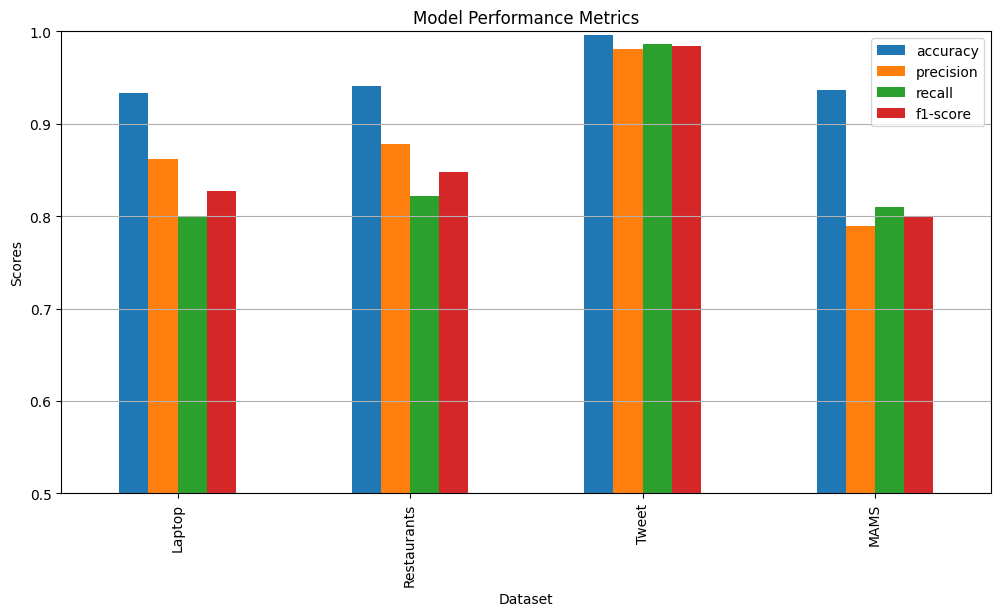

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, accuracy_score

# Your existing code to generate predictions and true labels
# ...

# Filter out 'PAD' tag from predictions and true labels
def filter_pad_tags(y_true_flat, y_pred_flat, pad_tag_index):
    non_pad_indices = y_true_flat != pad_tag_index
    y_true_filtered = y_true_flat[non_pad_indices]
    y_pred_filtered = y_pred_flat[non_pad_indices]
    return y_true_filtered, y_pred_filtered

pad_tag_index = tag_to_index['PAD']

# Filter the predictions and true labels
laptop_y_test_labels_filtered, laptop_y_pred_labels_filtered = filter_pad_tags(y_test_laptop_labels_flat, y_pred_laptop_labels_flat, pad_tag_index)
res_y_test_labels_filtered, res_y_pred_labels_filtered = filter_pad_tags(y_test_res_labels_flat, y_pred_res_labels_flat, pad_tag_index)
tweet_y_test_labels_filtered, tweet_y_pred_labels_filtered = filter_pad_tags(y_test_tweet_labels_flat, y_pred_tweet_labels_flat, pad_tag_index)
mams_y_test_labels_filtered, mams_y_pred_labels_filtered = filter_pad_tags(y_test_mams_labels_flat, y_pred_mams_labels_flat, pad_tag_index)

# Generate classification report and extract metrics
def extract_metrics(y_true, y_pred):
    report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)
    accuracy = accuracy_score(y_true, y_pred)
    metrics = {
        'accuracy': accuracy,
        'precision': report['macro avg']['precision'],
        'recall': report['macro avg']['recall'],
        'f1-score': report['macro avg']['f1-score']
    }
    return metrics

# Extracted metrics
laptop_metrics = extract_metrics(laptop_y_test_labels_filtered, laptop_y_pred_labels_filtered)
res_metrics = extract_metrics(res_y_test_labels_filtered, res_y_pred_labels_filtered)
tweet_metrics = extract_metrics(tweet_y_test_labels_filtered, tweet_y_pred_labels_filtered)
mams_metrics = extract_metrics(mams_y_test_labels_filtered, mams_y_pred_labels_filtered)

# Create a DataFrame
metrics_df = pd.DataFrame([laptop_metrics, res_metrics, tweet_metrics, mams_metrics],
                          index=['Laptop', 'Restaurants', 'Tweet', 'MAMS'])

# Plotting the histograms
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Model Performance Metrics')
plt.xlabel('Dataset')
plt.ylabel('Scores')
plt.ylim(0.5, 1)  # Since metrics range from 0 to 1
plt.legend(loc='upper right')
plt.grid(axis='y')

plt.savefig('model_performance_metrics.png', format='png')

# Show the plot
plt.show()


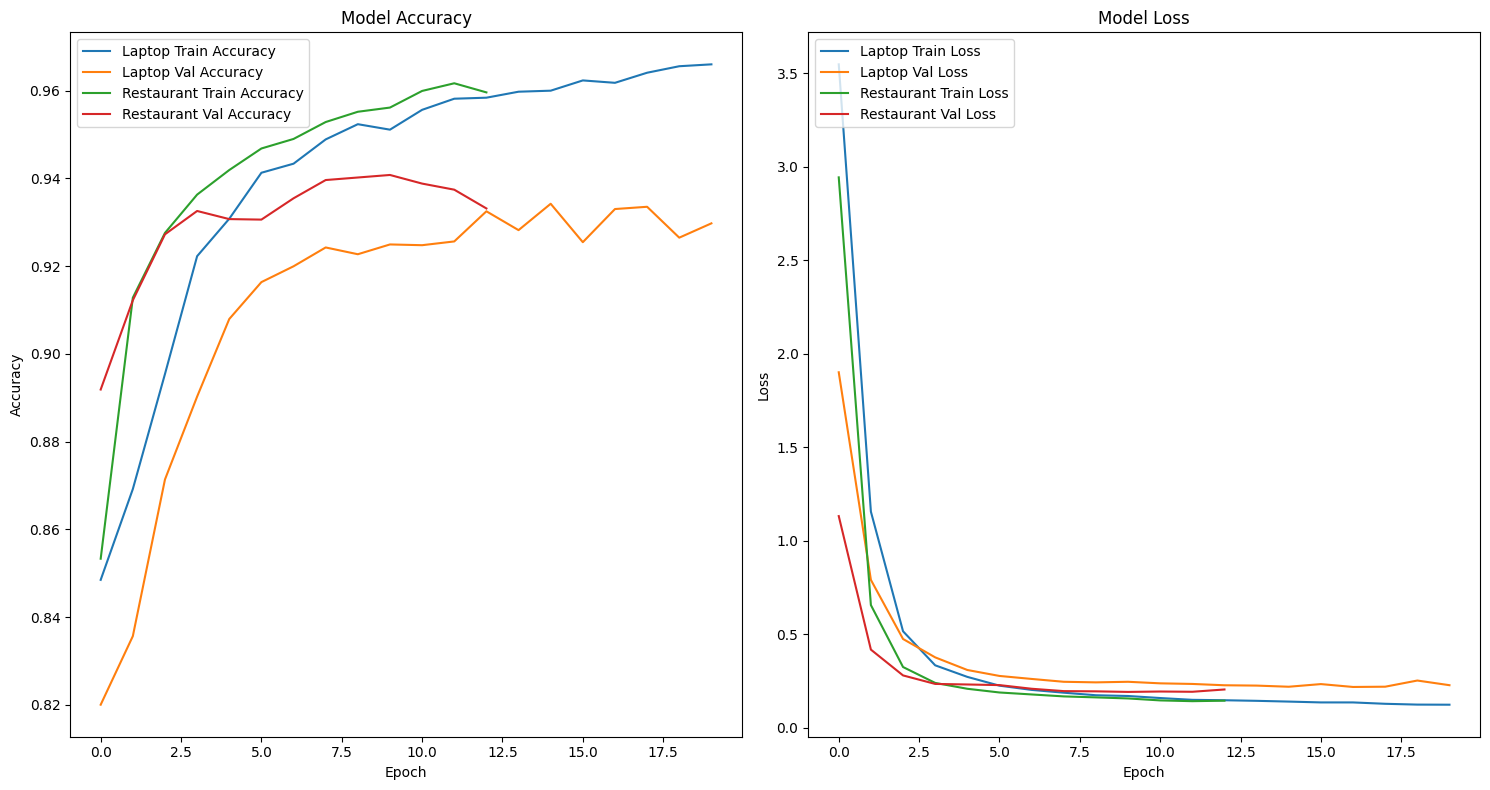

In [55]:
# Plot accuracy
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(laptop_history.history['accuracy'], label='Laptop Train Accuracy')
plt.plot(laptop_history.history['val_accuracy'], label='Laptop Val Accuracy')
plt.plot(res_history.history['accuracy'], label='Restaurant Train Accuracy')
plt.plot(res_history.history['val_accuracy'], label='Restaurant Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(laptop_history.history['loss'], label='Laptop Train Loss')
plt.plot(laptop_history.history['val_loss'], label='Laptop Val Loss')
plt.plot(res_history.history['loss'], label='Restaurant Train Loss')
plt.plot(res_history.history['val_loss'], label='Restaurant Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.tight_layout()
plt.savefig('model_accuracy_loss.png')
plt.show()

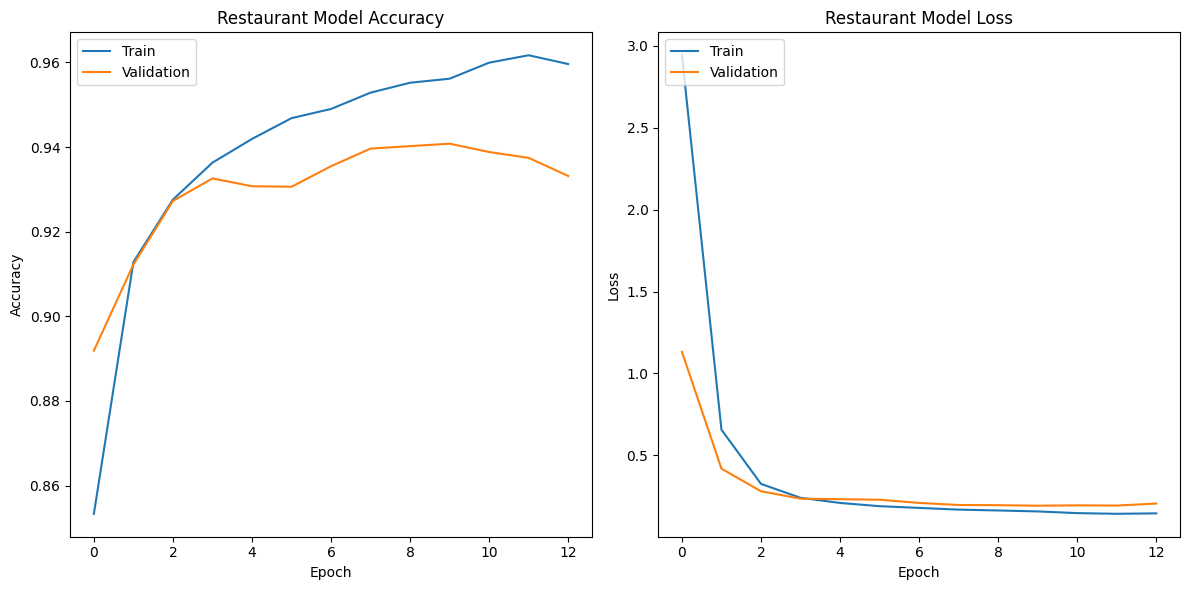

In [56]:
# Plot Restaurant dataset results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(res_history.history['accuracy'])
plt.plot(res_history.history['val_accuracy'])
plt.title('Restaurant Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(res_history.history['loss'])
plt.plot(res_history.history['val_loss'])
plt.title('Restaurant Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example tag_to_index and class_names definitions
tag_to_index = {'B': 0, 'I': 1, 'O': 2, 'PAD': 3}
class_names = ['B', 'I', 'O']  # Replace with your actual class names

# Function to filter out 'PAD' tags from predictions and true labels
def filter_pad_tags(y_true_flat, y_pred_flat, pad_tag_index):
    non_pad_indices = y_true_flat != pad_tag_index
    y_true_filtered = y_true_flat[non_pad_indices]
    y_pred_filtered = y_pred_flat[non_pad_indices]
    return y_true_filtered, y_pred_filtered

# Assuming y_test_*_labels_flat and y_pred_*_labels_flat are already defined
# Filter the predictions and true labels
pad_tag_index = tag_to_index['PAD']

laptop_y_test_labels_filtered, laptop_y_pred_labels_filtered = filter_pad_tags(y_test_laptop_labels_flat, y_pred_laptop_labels_flat, pad_tag_index)
res_y_test_labels_filtered, res_y_pred_labels_filtered = filter_pad_tags(y_test_res_labels_flat, y_pred_res_labels_flat, pad_tag_index)
tweet_y_test_labels_filtered, tweet_y_pred_labels_filtered = filter_pad_tags(y_test_tweet_labels_flat, y_pred_tweet_labels_flat, pad_tag_index)
mams_y_test_labels_filtered, mams_y_pred_labels_filtered = filter_pad_tags(y_test_mams_labels_flat, y_pred_mams_labels_flat, pad_tag_index)

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()



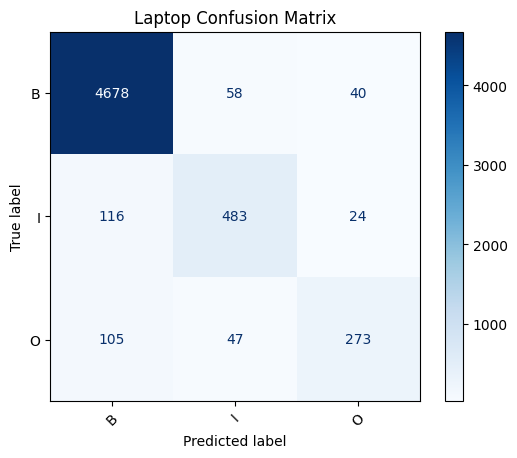

In [66]:
plot_confusion_matrix(laptop_y_test_labels_filtered, laptop_y_pred_labels_filtered, class_names, 'Laptop Confusion Matrix')

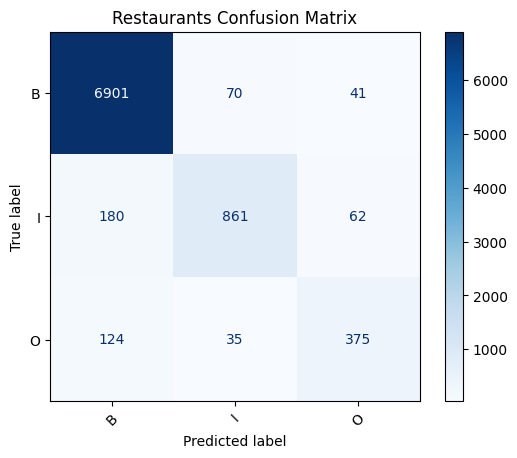

In [62]:
plot_confusion_matrix(res_y_test_labels_filtered, res_y_pred_labels_filtered, class_names, 'Restaurants Confusion Matrix')

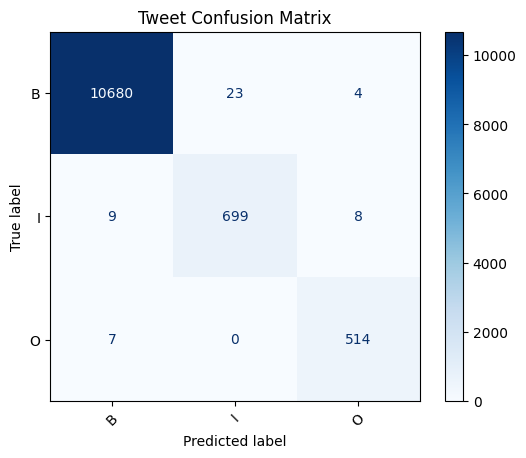

In [63]:
plot_confusion_matrix(tweet_y_test_labels_filtered, tweet_y_pred_labels_filtered, class_names, 'Tweet Confusion Matrix')

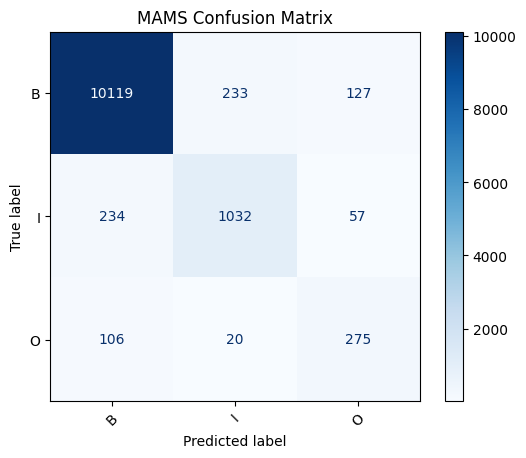

In [64]:
plot_confusion_matrix(mams_y_test_labels_filtered, mams_y_pred_labels_filtered, class_names, 'MAMS Confusion Matrix')